In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive

from utils import *

C:\Users\tripl\AppData\Local\Temp\ipykernel_19256\804203489.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\tripl\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def model3(game_info, obs=None):
    """
    Inputs:
        obs: obs: A 1D tensor of observed data. The length should be equal to the number of games played.
             Represents the outcome of a game in the eyes of coach 1, i.e. coach 1 wins: obs = 1, coach 2 wins: obs = -1.
        ids1: A 1D tensor of the same length as obs. Contains the index of the first coach in each game.
        ids2: A 1D tensor of the same length as obs. Contains the index of the second coach in each game.
        num_coaches: The number of coaches in the dataset.

    Output: A 1D tensor of the same length as "obs". Represents a sample from difference in performance between the two coaches.
    """

    # Extract the data
    ids1 = game_info['coach1_ids']
    ids2 = game_info['coach2_ids']
    num_coaches = game_info['num_coaches']

    hyper_sigma = 1/8
    
    coach_mu_skill = 0
    coach_sigma_skill = 1

    # Sample skills for each coach using a plate for coaches
    with pyro.plate('coaches', num_coaches):
        coach_skills = pyro.sample("coach_skills", dist.Normal(coach_mu_skill, coach_sigma_skill))
    
    with pyro.plate('matches', obs.shape[0]):
        # Gather the skills for the competing coaches in each match
        coach1_skills = coach_skills[ids1]
        coach2_skills = coach_skills[ids2]

        # Sample performances for the coaches in each match
        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skills, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skills, hyper_sigma))

        # Compute the performance difference
        perf_diff = coach1_perf - coach2_perf

        # Sample the observed outcomes
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

In [3]:
# Fake data to see if this model gets same results as previous model
num_games = 12
obs = torch.ones(num_games)
id1 = torch.zeros(len(obs)).long()
id2 = torch.ones(len(obs)).long()
num_coaches = 2

game_info = {'coach1_ids': id1, 'coach2_ids': id2, 'num_coaches': num_coaches}

guide = AutoNormal(model3)
run_inference(model3, guide, game_info, obs)

  0%|          | 0/2000 [00:00<?, ?it/s]

Loss = -2.358894: 100%|██████████| 2000/2000 [00:22<00:00, 88.72it/s] 


[396.3108311891556,
 381.53725278377533,
 319.809445142746,
 307.6547214984894,
 327.93101930618286,
 324.209016084671,
 298.25198006629944,
 300.7042348384857,
 262.45086884498596,
 263.35474729537964,
 245.4217472076416,
 291.65627121925354,
 274.0533182621002,
 249.78985714912415,
 222.9860461950302,
 188.91145634651184,
 205.54407250881195,
 184.00217008590698,
 153.9535973072052,
 162.54523980617523,
 180.0548998117447,
 181.09831643104553,
 158.31950557231903,
 135.7840850353241,
 121.69380402565002,
 125.06778228282928,
 84.81958401203156,
 110.5193042755127,
 114.9326286315918,
 77.70037972927094,
 93.8969075679779,
 105.45478081703186,
 91.54344022274017,
 80.51577603816986,
 69.73379909992218,
 70.25588667392731,
 75.94460701942444,
 70.19037628173828,
 85.80453515052795,
 61.10633456707001,
 49.254727363586426,
 52.56267476081848,
 59.52781367301941,
 42.14948058128357,
 61.20269274711609,
 25.2943434715271,
 27.91204333305359,
 37.814690589904785,
 31.058400988578796,
 16.4

In [4]:
predictive = Predictive(model3, guide=guide, num_samples=2000)

samples = predictive(game_info, obs)

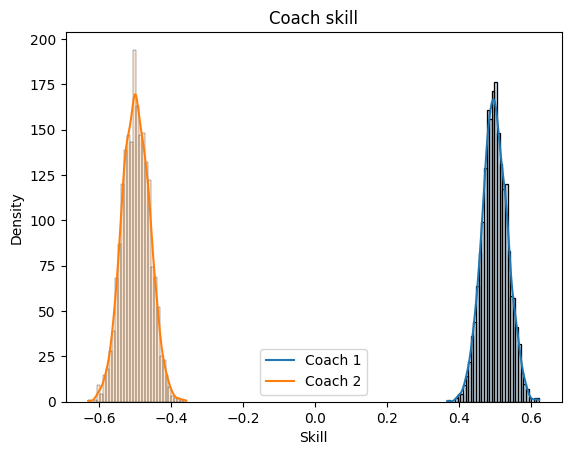

In [5]:
labels = []
for i in range(num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1}")

plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()

# Try and make some fake data with multiple players where the player with the higher index always wins.

In [6]:
num_coaches = 6
# assuming round robin
num_games = 15

# round robin structure generated by chatgpt
id1 = [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5]
id2 = [2, 3, 4, 5, 6, 3, 4, 5, 6, 4, 5, 6, 5, 6, 6]

id1 = torch.tensor(id1).long()
id1 = id1 - 1
id2 = torch.tensor(id2).long()
id2 = id2 - 1

obs = []
for i in range(num_games):
    if id1[i] < id2[i]:
        obs.append(-1)
    else:
        obs.append(1)

obs = torch.tensor(obs)

game_info = {'coach1_ids': id1, 'coach2_ids': id2, 'num_coaches': num_coaches}

In [7]:
guide = AutoNormal(model3)
run_inference(model3, guide, game_info, obs)

Loss = 51.373746: 100%|██████████| 2000/2000 [00:23<00:00, 84.28it/s] 


[489.5413064956665,
 456.7598214149475,
 454.211154460907,
 462.6120171546936,
 456.9417462348938,
 382.97676944732666,
 335.6400194168091,
 390.40128660202026,
 348.671573638916,
 324.7651286125183,
 330.039954662323,
 304.886127948761,
 316.69508266448975,
 296.69198989868164,
 284.1048182249069,
 279.0248484611511,
 288.13431882858276,
 259.3918845653534,
 232.45317125320435,
 254.24775218963623,
 245.78267431259155,
 217.128009557724,
 197.36845076084137,
 204.13750791549683,
 211.39346981048584,
 192.06982946395874,
 201.84790992736816,
 177.4658501148224,
 174.10187005996704,
 192.89942264556885,
 162.08743977546692,
 151.06282567977905,
 155.8612664937973,
 172.63618183135986,
 154.31363260746002,
 155.14578866958618,
 143.60493183135986,
 120.69884252548218,
 137.7147547006607,
 133.80845499038696,
 107.73490524291992,
 118.69628715515137,
 124.19759726524353,
 122.49720668792725,
 132.65316247940063,
 116.17369747161865,
 104.03547239303589,
 119.74459934234619,
 100.280683040

In [8]:
predictive = Predictive(model3, guide=AutoNormal(model3), num_samples=2000)

samples = predictive(game_info, obs)

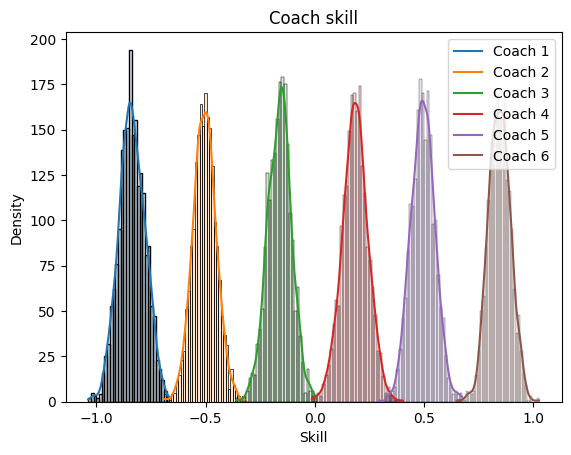

In [9]:
labels = []
for i in range(num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


# Try training on real data

In [10]:
# read and format data
df = pd.read_csv('../data/X_train.csv')

# make a list of unique coaches
coaches1 = df['team1_coach_id']
coaches2 = df['team2_coach_id']
unique_coaches = pd.concat([coaches1, coaches2]).unique()
unique_coaches.sort()

num_coaches = len(unique_coaches)

coach_winrates = np.zeros(num_coaches)
coach_num_matches = np.zeros(num_coaches)

# doesn't work properly
# for id, coach_id in enumerate(unique_coaches):
#     coach1_df = df[df['team1_coach_id'] == coach_id]

#     coach_winrates[id] += 0.5 * (coach1_df["team1_win"] == 0).sum()
#     coach_winrates[id] += (coach1_df["team1_win"] == 1).sum()

#     coach2_df = df[df['team2_coach_id'] == coach_id]
#     coach_winrates[id] += 0.5 * (coach1_df["team2_win"] == 0).sum()
#     coach_winrates[id] += (coach2_df["team2_win"] == 1).sum()

#     coach_winrates[id] = coach_winrates[id] / (len(coach1_df) + len(coach2_df))
#     coach_num_matches[id] = len(coach1_df) + len(coach2_df)

# alternative winrate and num games calculation
# works properly
coach_winrates = np.zeros(num_coaches)
coach_num_matches = np.zeros(num_coaches)
coach_num_wins = np.zeros(num_coaches)
coach_num_draws = np.zeros(num_coaches)

for id, coach_id in enumerate(unique_coaches):
    coach_num_matches[id]  = len(df[(df['team1_coach_id'] == coach_id) | (df['team2_coach_id'] == coach_id)])
    coach_num_wins[id] = df[(df['team1_coach_id'] == coach_id) & (df['team1_win'] == 1)].shape[0] + df[(df['team2_coach_id'] == coach_id) & (df['team2_win'] == 1)].shape[0]
    coach_num_draws[id] = df[(df['team1_coach_id'] == coach_id) & (df['team1_win'] == 0)].shape[0] + df[(df['team2_coach_id'] == coach_id) & (df['team2_win'] == 0)].shape[0]
    coach_winrates[id] = (coach_num_wins[id] + 0.5 * coach_num_draws[id]) / coach_num_matches[id]

indices = np.lexsort((unique_coaches, coach_winrates, coach_num_matches))
# might fuck up when several coaches has the same number of matches.
sorted_coaches = unique_coaches[indices[::-1]]
sorted_winrates = coach_winrates[indices[::-1]]
sorted_num_matches = coach_num_matches[indices[::-1]]

coach_dict = {coach: i for i, coach in enumerate(sorted_coaches)}

# make variables for the model sorted by winrate
id1 = torch.tensor(coaches1.map(coach_dict).values).long()
id2 = torch.tensor(coaches2.map(coach_dict).values).long()

obs = torch.tensor(df['team1_win'].values)

game_info = {'coach1_ids': id1, 'coach2_ids': id2, 'num_coaches': num_coaches}



In [11]:
guide = AutoNormal(model3)
run_inference(model3, guide, game_info, obs)

Loss = 454485.632324: 100%|██████████| 2000/2000 [01:45<00:00, 18.90it/s]


[1938431.2946777344,
 1867895.283203125,
 1786607.0500488281,
 1723300.6354980469,
 1654555.9694824219,
 1591670.8801269531,
 1529998.9011230469,
 1464110.9899902344,
 1410638.4692382812,
 1356338.5588378906,
 1302706.1037597656,
 1251855.3715820312,
 1204587.6162109375,
 1157951.5766601562,
 1118457.3547363281,
 1073177.3686523438,
 1036882.7434082031,
 994650.0401611328,
 965899.9375,
 931871.9853515625,
 898031.8811035156,
 870530.0034179688,
 845776.9138183594,
 817841.9162597656,
 795488.8359375,
 769773.2414550781,
 754773.3264160156,
 733706.494140625,
 716834.5278320312,
 700981.4753417969,
 687995.50390625,
 676403.9143066406,
 664561.8200683594,
 651636.5815429688,
 641670.8898925781,
 633177.3239746094,
 624528.7998046875,
 616583.6955566406,
 610202.2666015625,
 606233.7954101562,
 601682.4067382812,
 591928.2946777344,
 592006.5629882812,
 590207.6684570312,
 584261.3493652344,
 580794.9465332031,
 575416.6115722656,
 573312.3081054688,
 575792.7707519531,
 575012.99145507

In [12]:
predictive = Predictive(model3, guide=AutoNormal(model3), num_samples=2000)

samples = predictive(game_info, obs)

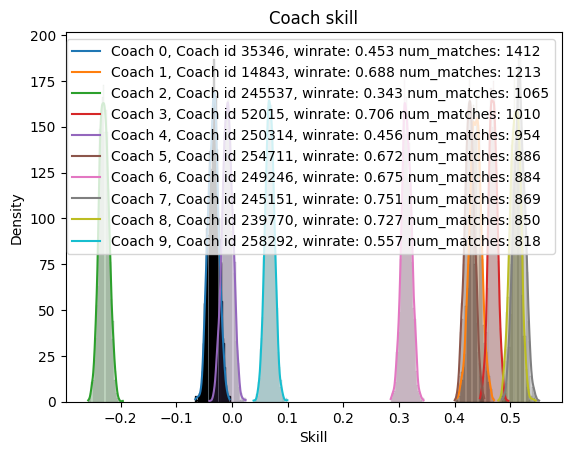

In [28]:
a = 0
b = 10

labels = []
for i in range(a,b):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i}, Coach id {sorted_coaches[i]}, winrate: {sorted_winrates[i]:.3f} num_matches: {int(sorted_num_matches[i])}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()



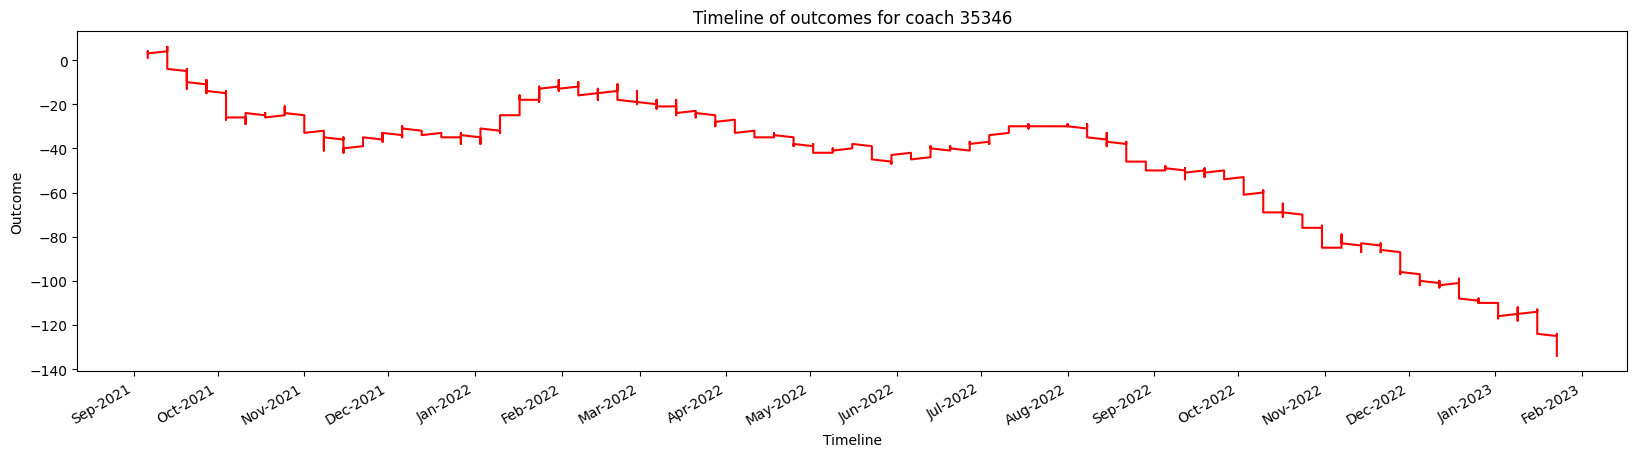

Coach id: 35346 Coach number: 1
Number of wins for team 1: 483
Number of draws for team 1: 312
Number of losses for team 1: 617
Total number of games: 1412
Win rate for team 1: 0.45254957507082155


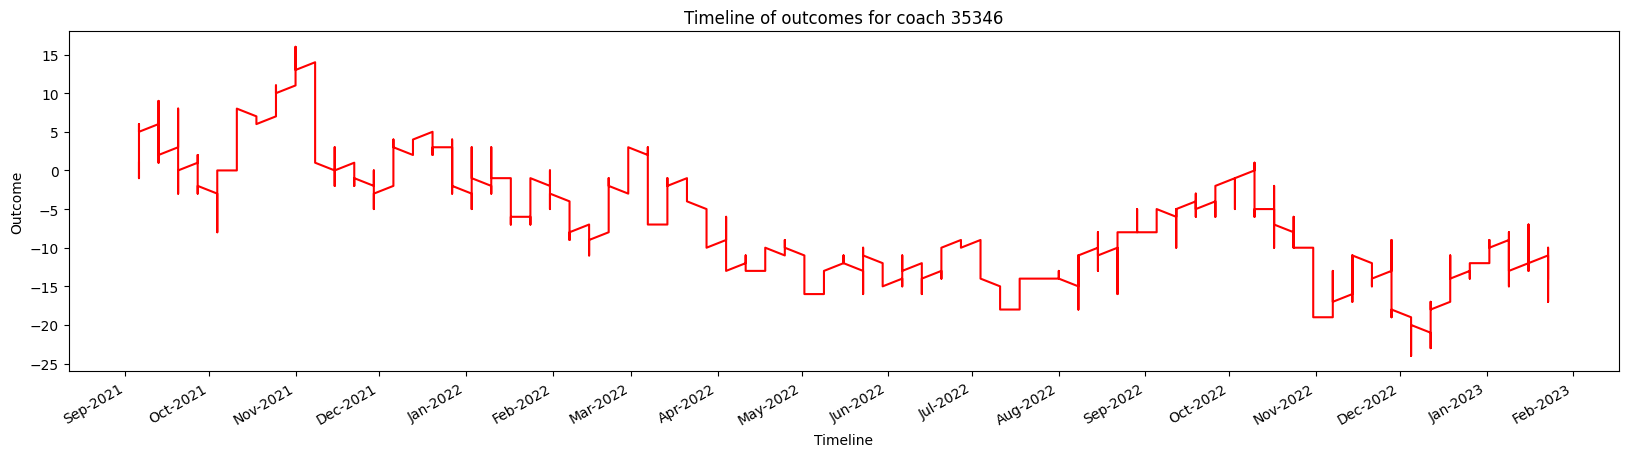

Coach id: 35346 Coach number: 1
Number of wins for team 1: 543
Number of draws for team 1: 312
Number of losses for team 1: 557
Total number of games: 1412
Win rate for team 1: 0.495042492917847


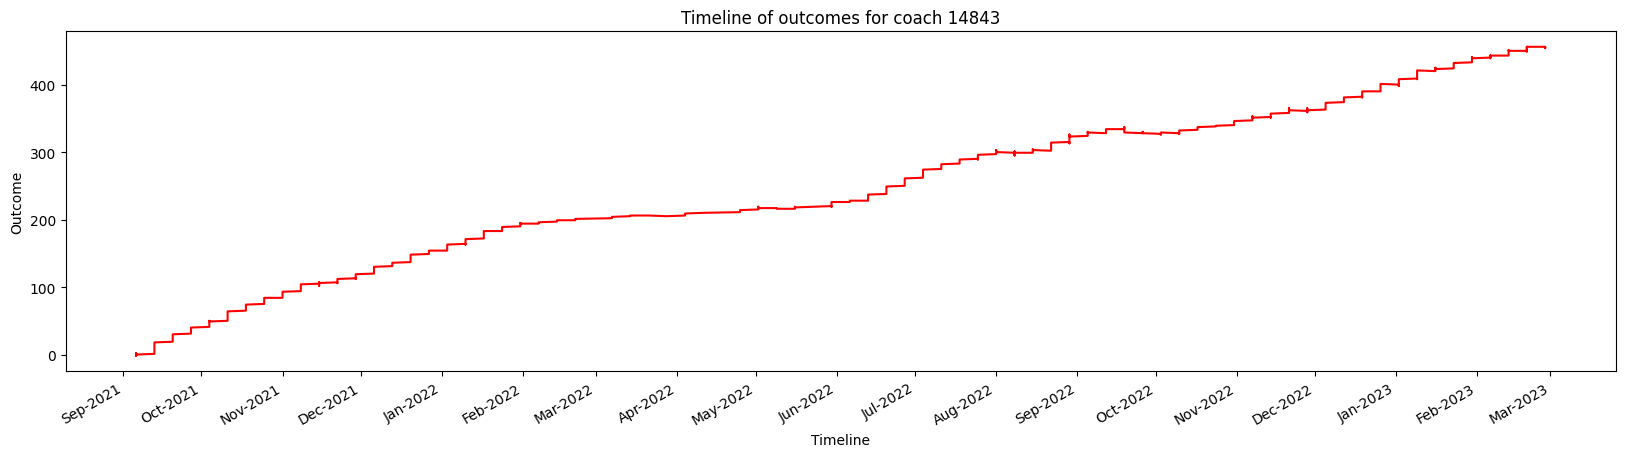

Coach id: 14843 Coach number: 2
Number of wins for team 1: 714
Number of draws for team 1: 240
Number of losses for team 1: 259
Total number of games: 1213
Win rate for team 1: 0.6875515251442704


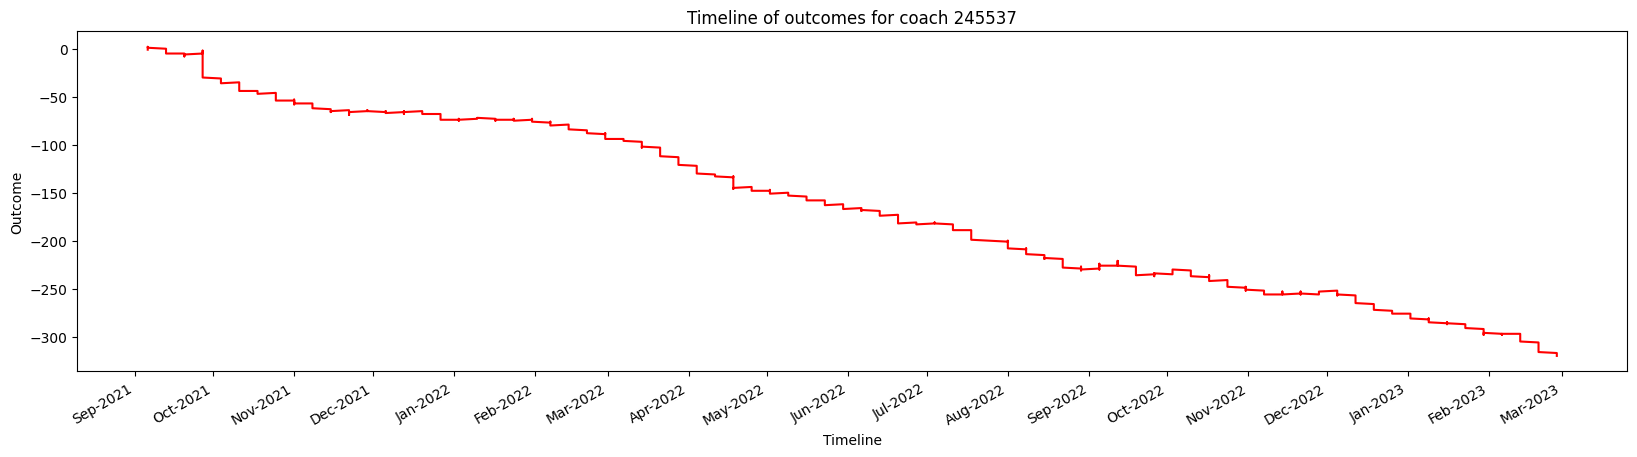

Coach id: 245537 Coach number: 3
Number of wins for team 1: 262
Number of draws for team 1: 221
Number of losses for team 1: 582
Total number of games: 1065
Win rate for team 1: 0.34976525821596244


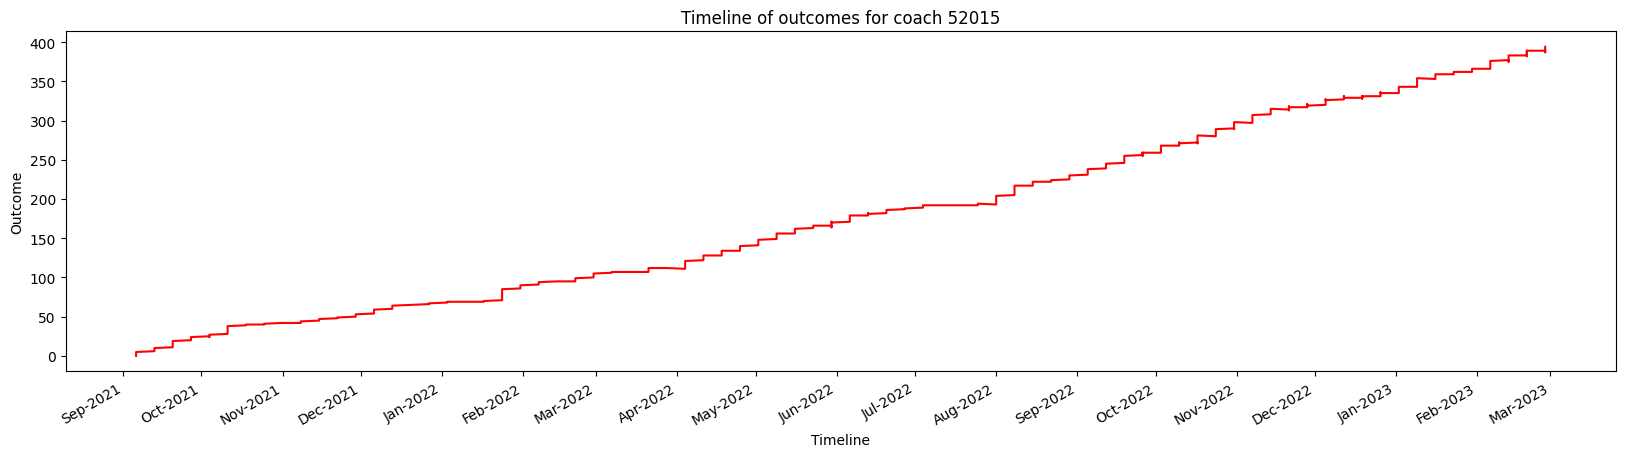

Coach id: 52015 Coach number: 4
Number of wins for team 1: 542
Number of draws for team 1: 320
Number of losses for team 1: 148
Total number of games: 1010
Win rate for team 1: 0.695049504950495


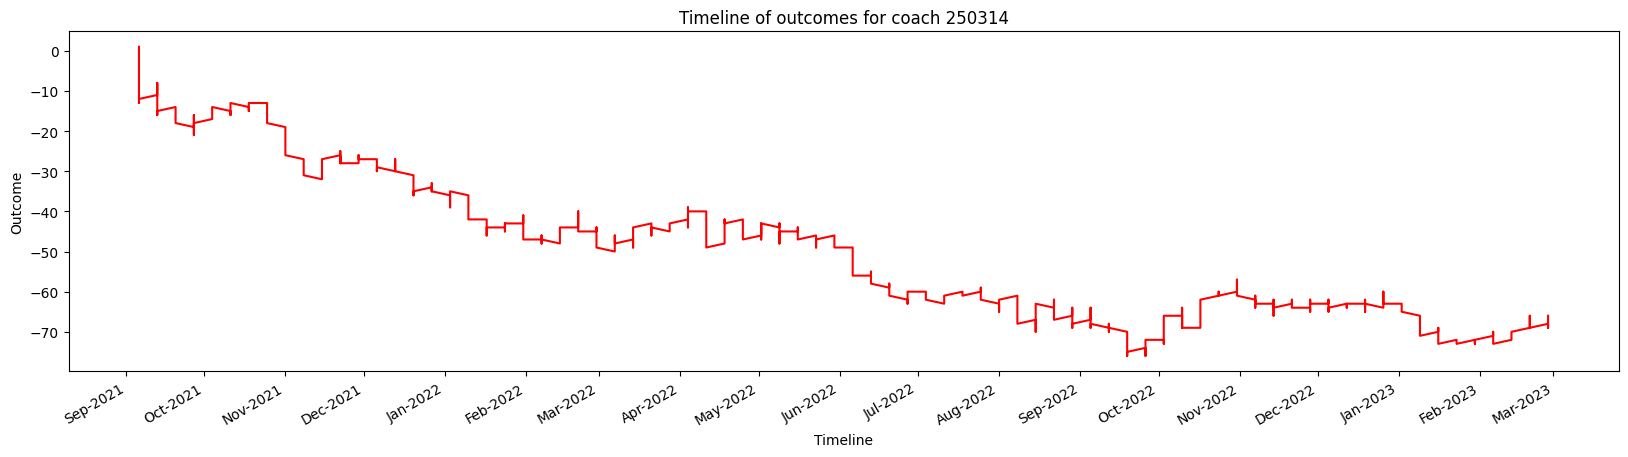

Coach id: 250314 Coach number: 5
Number of wins for team 1: 334
Number of draws for team 1: 220
Number of losses for team 1: 400
Total number of games: 954
Win rate for team 1: 0.46540880503144655


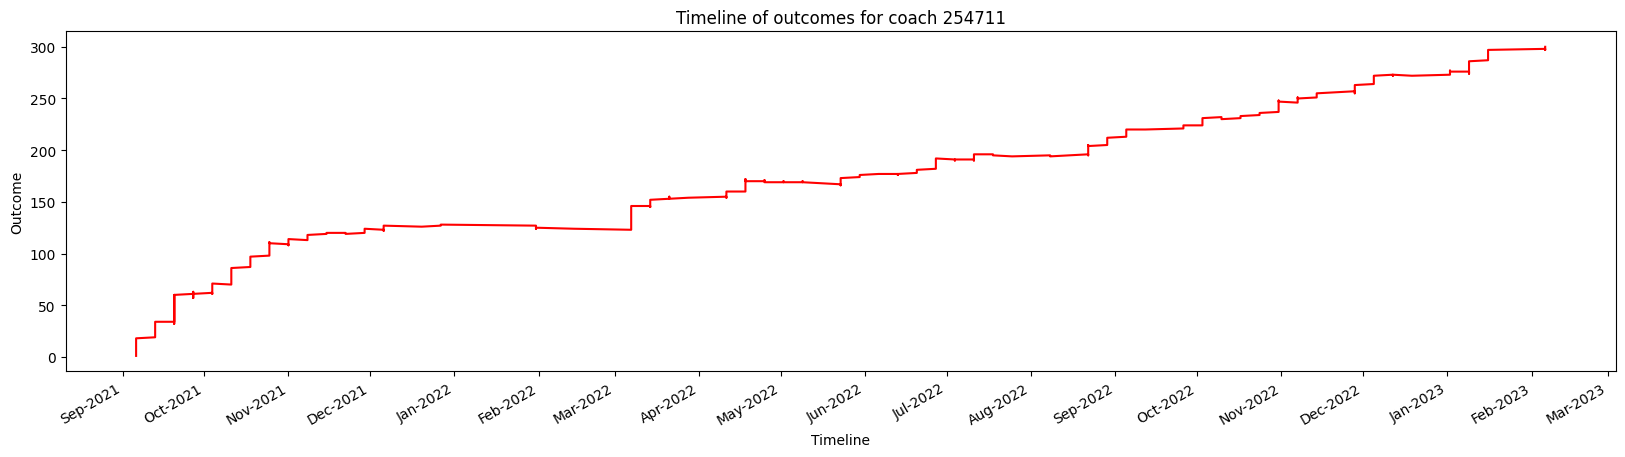

Coach id: 254711 Coach number: 6
Number of wins for team 1: 485
Number of draws for team 1: 216
Number of losses for team 1: 185
Total number of games: 886
Win rate for team 1: 0.6693002257336343


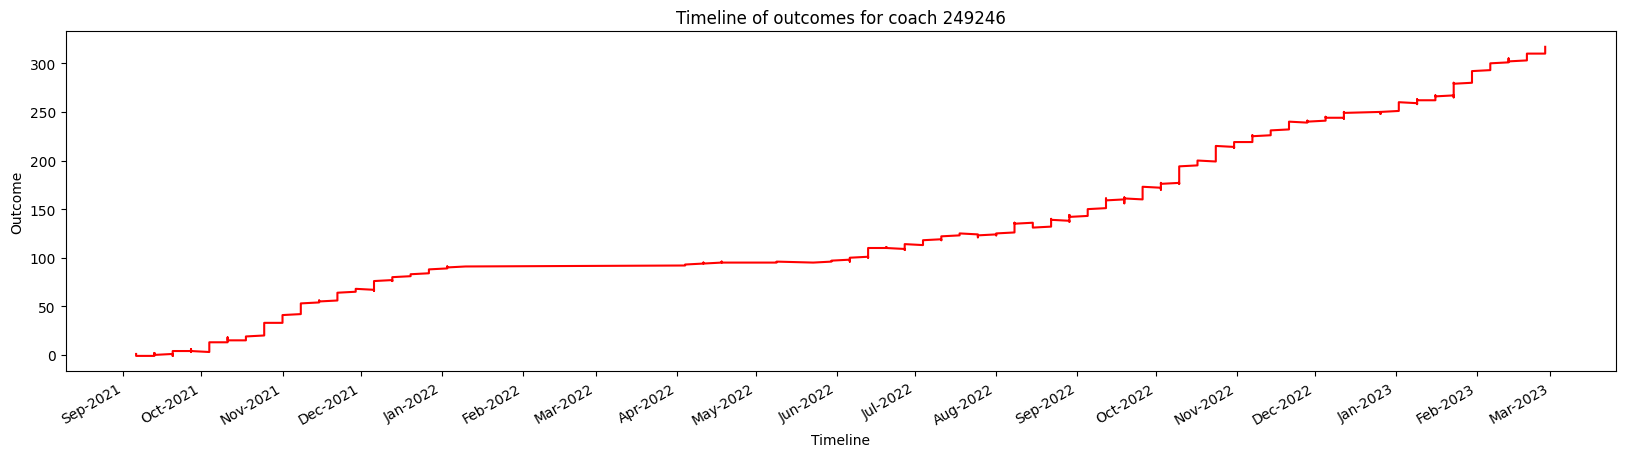

Coach id: 249246 Coach number: 7
Number of wins for team 1: 521
Number of draws for team 1: 159
Number of losses for team 1: 204
Total number of games: 884
Win rate for team 1: 0.6792986425339367


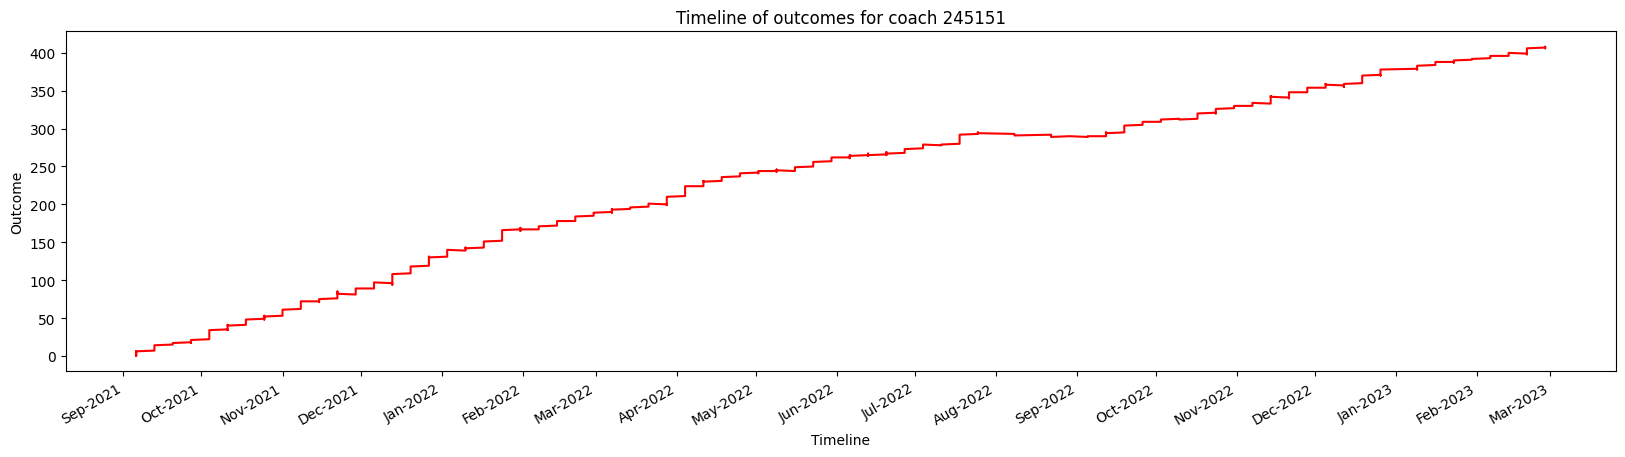

Coach id: 245151 Coach number: 8
Number of wins for team 1: 550
Number of draws for team 1: 177
Number of losses for team 1: 142
Total number of games: 869
Win rate for team 1: 0.7347525891829689


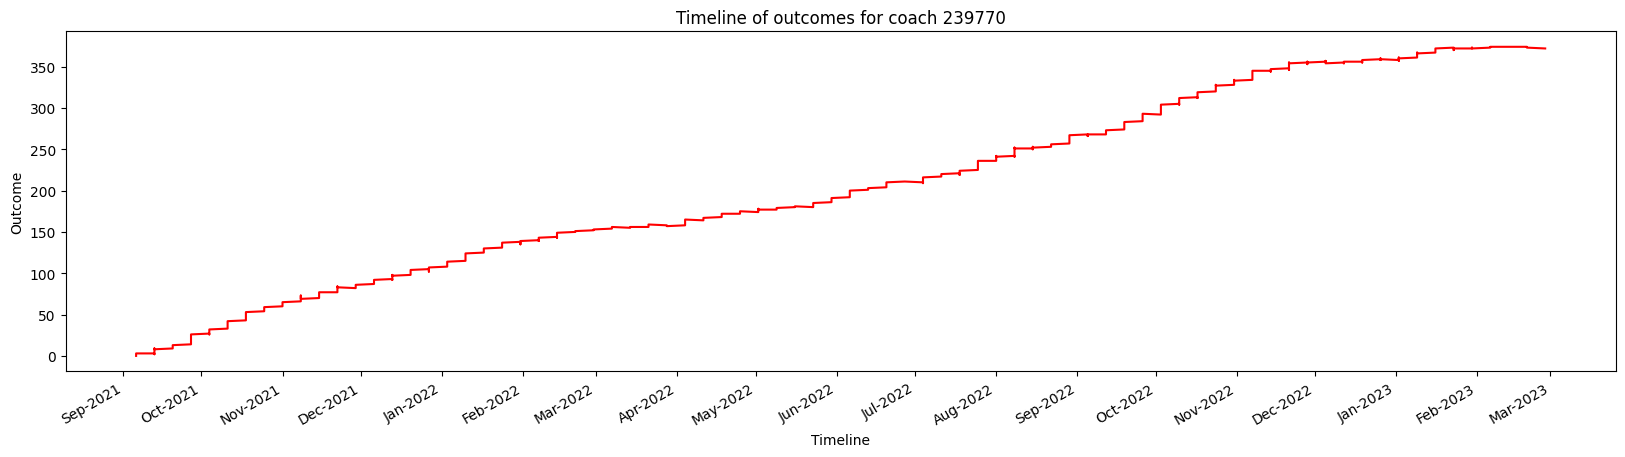

Coach id: 239770 Coach number: 9
Number of wins for team 1: 530
Number of draws for team 1: 162
Number of losses for team 1: 158
Total number of games: 850
Win rate for team 1: 0.7188235294117648


In [31]:
import matplotlib.dates as mdates

df = pd.read_csv('../data/X_train.csv')

# function for plotting the timeline of a coach etc.
def new_func(df, coach_index):
    coach_id = sorted_coaches[coach_index]

    mask = df['team2_coach_id'] == coach_id
    df.loc[mask, 'team2_win'] *= -1
    df.loc[mask, 'team1_win'] *= -1

    coach1_df = df[df['team1_coach_id'] == coach_id].copy()
    coach2_df = df[df['team2_coach_id'] == coach_id].copy()

    coach_df = pd.concat([coach1_df, coach2_df])
    coach_df['week_date'] = pd.to_datetime(coach_df['week_date'])
    coach_df = coach_df.sort_values(by='week_date')

# plot the timeline of outcomes for the given coach
    plt.figure(figsize=(20, 5))
    plt.plot(coach_df['week_date'], np.cumsum(coach_df['team1_win']), 'r')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  # 'Month-Year' format
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # set locator to month
    plt.gcf().autofmt_xdate()  # autoformat the x-axis date
    plt.xlabel("Timeline")
    plt.ylabel("Outcome")
    plt.title(f"Timeline of outcomes for coach {coach_id}")
    plt.show()

# Print the coach id and number
    print("Coach id:", coach_id, "Coach number:", coach_index + 1)

# Print the number of wins for team 1
    print("Number of wins for team 1:", (coach_df['team1_win'] == 1).sum())

# Print the number of draws for team 1
    print("Number of draws for team 1:", (coach_df['team1_win'] == 0).sum())

# Print the number of losses for team 1
    print("Number of losses for team 1:", (coach_df['team1_win'] == -1).sum())

# Print the total number of games
    print("Total number of games:", len(coach_df))

# Print the win rate for team 1
    win_rate = ((coach_df['team1_win'] == 1).sum() + (coach_df['team1_win'] == 0).sum() / 2) / len(coach_df)
    print("Win rate for team 1:", win_rate)

new_func(df, coach_index)

for i in range(a,b):
    new_func(df, i)